#Permite chequear que los XMLs asociados a las imágenes no tengan errores y visualizar los box para comprobar que sean correctos:


1) Cargar librerías:

In [14]:
#@title Cargar Librerías
from IPython.display import Image, display
from PIL import Image as ImPIL
import numpy as np
import os
import cv2
import os.path

import tensorflow as tf
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

import xml.etree.cElementTree as ET

print ("Librerías cargadas.")

Librerías cargadas.


2) Montar el Drive:

In [15]:
#@title
# monta Google Drive:
# Nota: la primera vez se debe confirmar el uso logueandose en "Google Drive File Stream" y obteniendo código de autentificación.
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


3) Llevar a cabo la prueba:

In [16]:
#@title define parámetros a utilizar { run: "auto" }

cantMuestraMostrar =  50#@param {type:"integer"}

levantarSoloDA =  True #@param {type:"boolean"}


mostrarImagenOriginal = False #@param {type:"boolean"}

extraerObjetos = False #@param {type:"boolean"}

mostrarObjetosEnImagen = True #@param {type:"boolean"}

print("Parámetros definidos.")

Parámetros definidos.


In [17]:
#@title Determina XML a mostrar
# define la carpeta donde están las imágenes para procesar
drive_path = '/content/gdrive/My Drive/GEMIS/objDetectionCursogramas/Cursogramas'
data_dir_path = drive_path + '/Generados'
image_dir_path = data_dir_path

# levanta los XML  para procesar
all_xml_array = [ fn for fn in os.listdir( data_dir_path ) if fn.endswith('.xml')  ]
if levantarSoloDA:
  all_xml_array = [ fn for fn in all_xml_array if fn.startswith('da')  ]

# desordena y toma algunos al azar
if len(all_xml_array)>cantMuestraMostrar:
  np.random.shuffle(all_xml_array)
  mostrar_xml_array, _ = np.split(np.array(all_xml_array), [cantMuestraMostrar])
else:
  mostrar_xml_array = np.array(all_xml_array)

print("> XML a probar: ", len(all_xml_array))
print("> XML a mostrar: ", len(mostrar_xml_array))

> XML a probar:  932
> XML a mostrar:  50




 1 >  da_curso_SFRV_000072-z40.xml




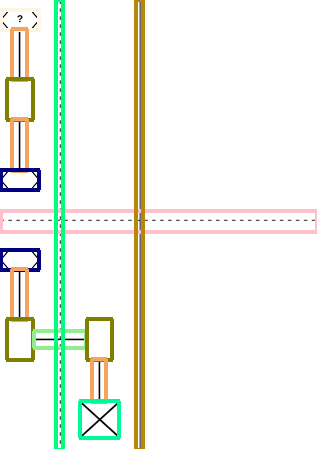



 2 >  da_curso_SARV_000029-z56.xml




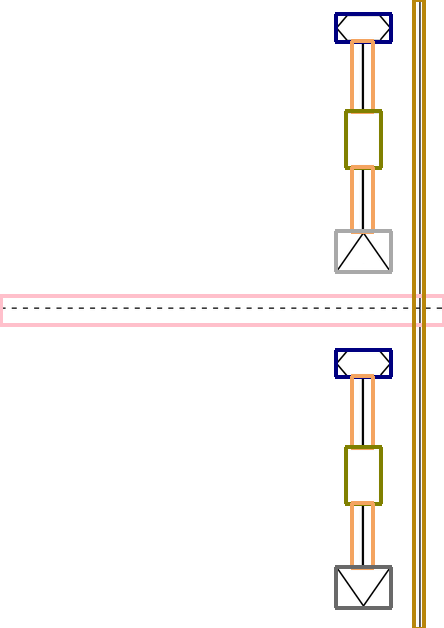



 3 >  da_curso_SPRV_000229-z56.xml




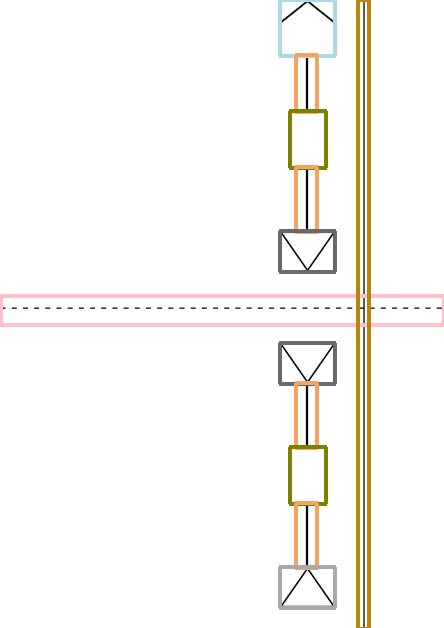



 4 >  da_curso_SARV_000272-z29.xml




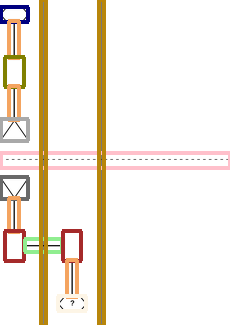



 5 >  da_curso_SARV_000209-z45.xml




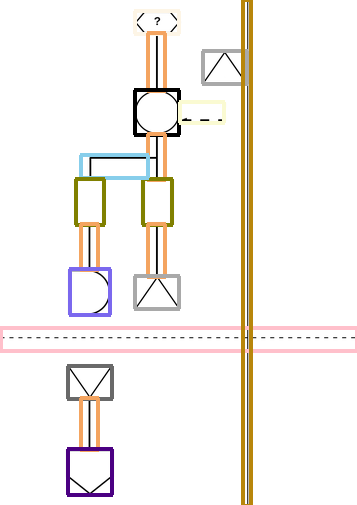



 6 >  da_curso_SFRS_000132-z77.xml




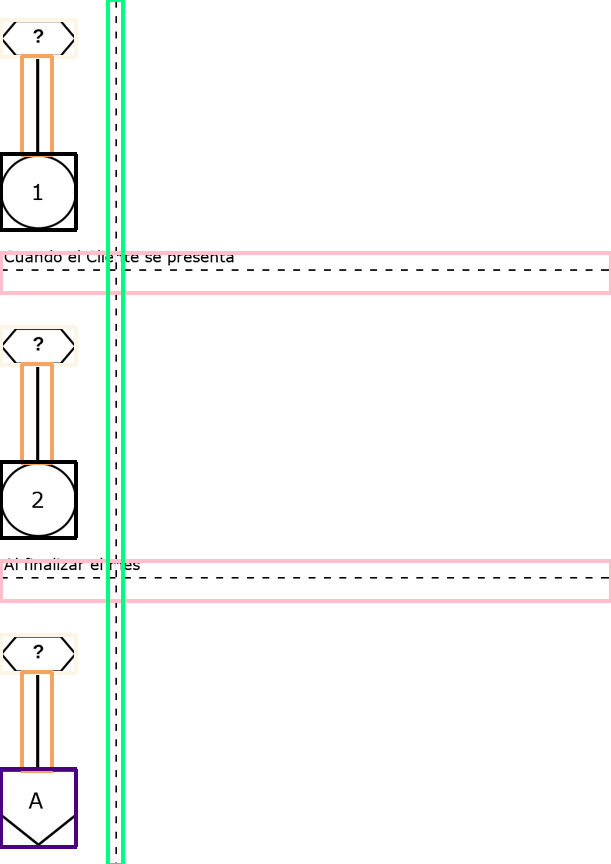



 7 >  da_curso_SARA_000110-z54.xml




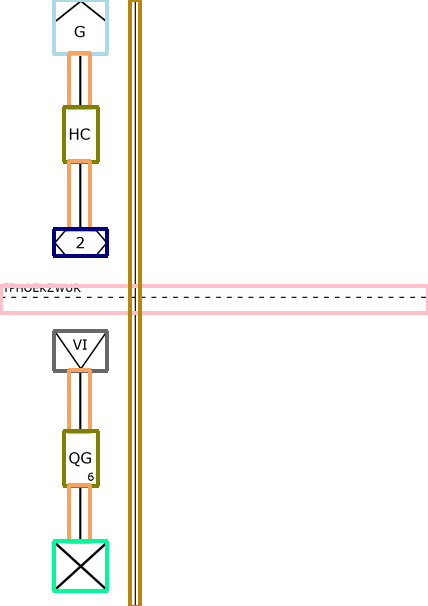



 8 >  da_curso_SFRS_000171-z71.xml




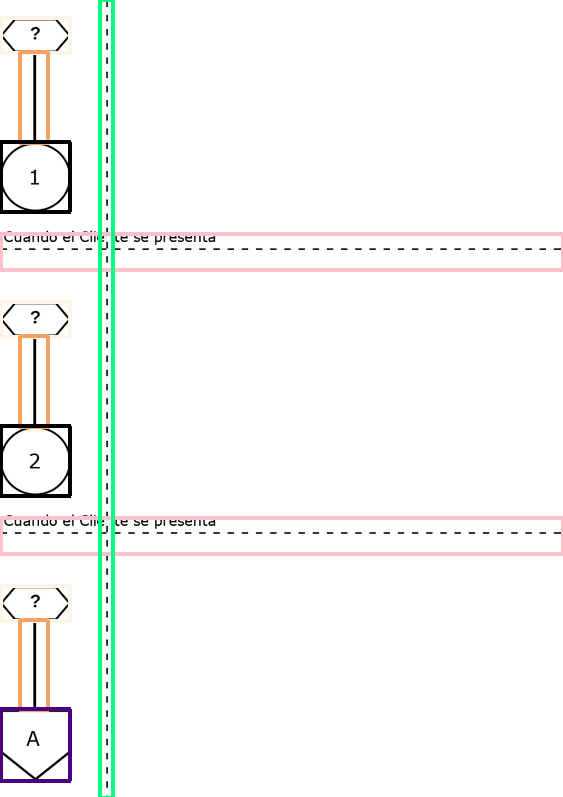



 9 >  da_curso_SARS_000061-z73.xml




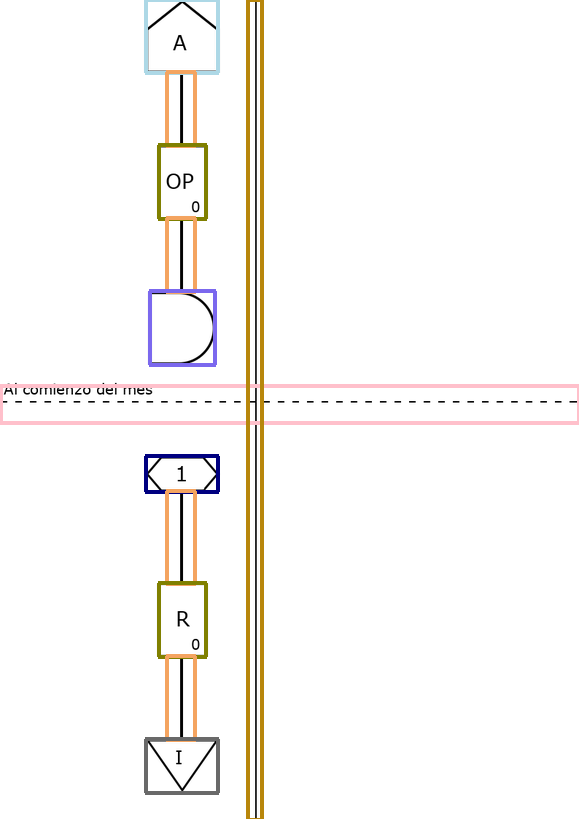



 10 >  da_curso_SPRV_000073-z88.xml




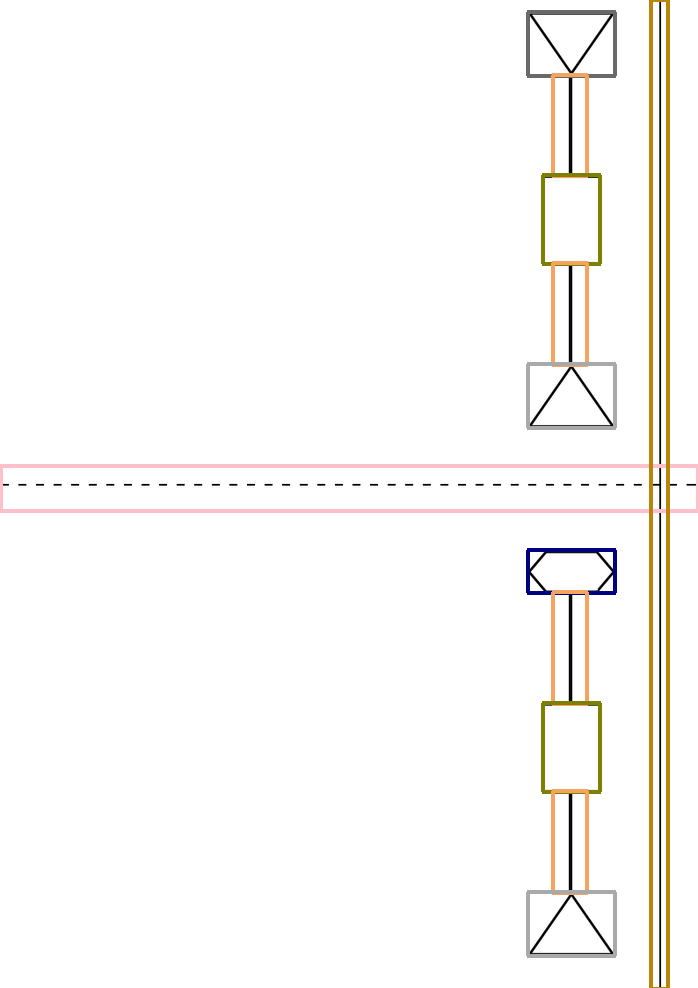



 11 >  da_curso_SFRA_000024-z88.xml




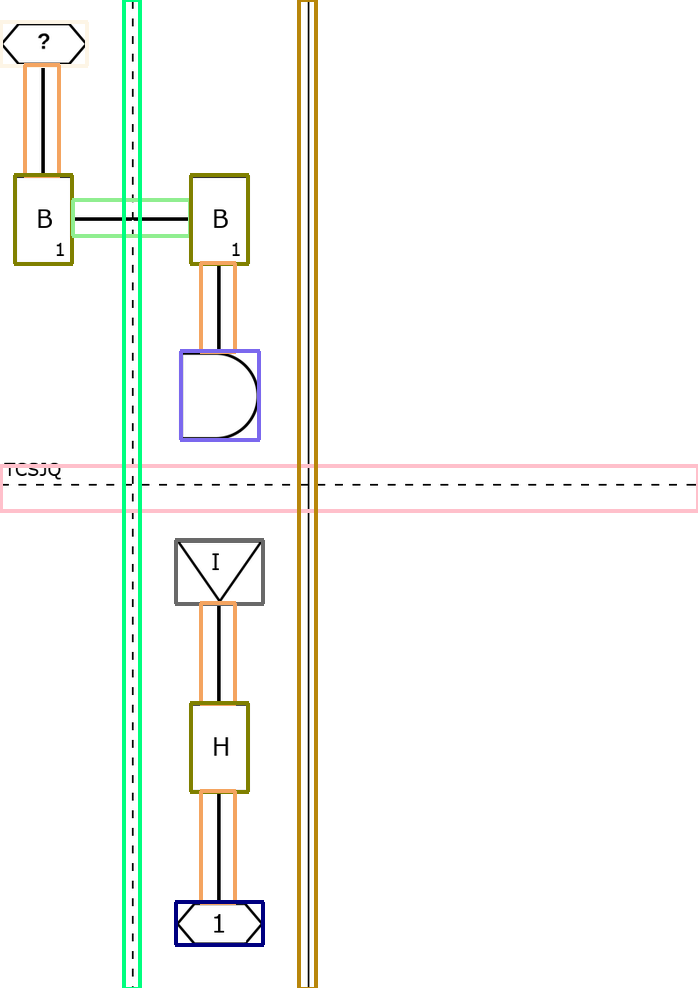



 12 >  da_curso_SFRA_000003-z49.xml




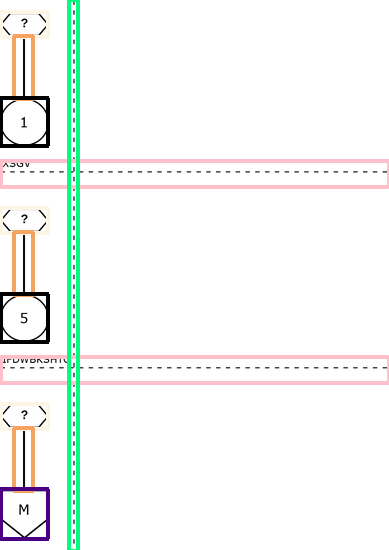



 13 >  da_curso_SPRC_000046-z82.xml




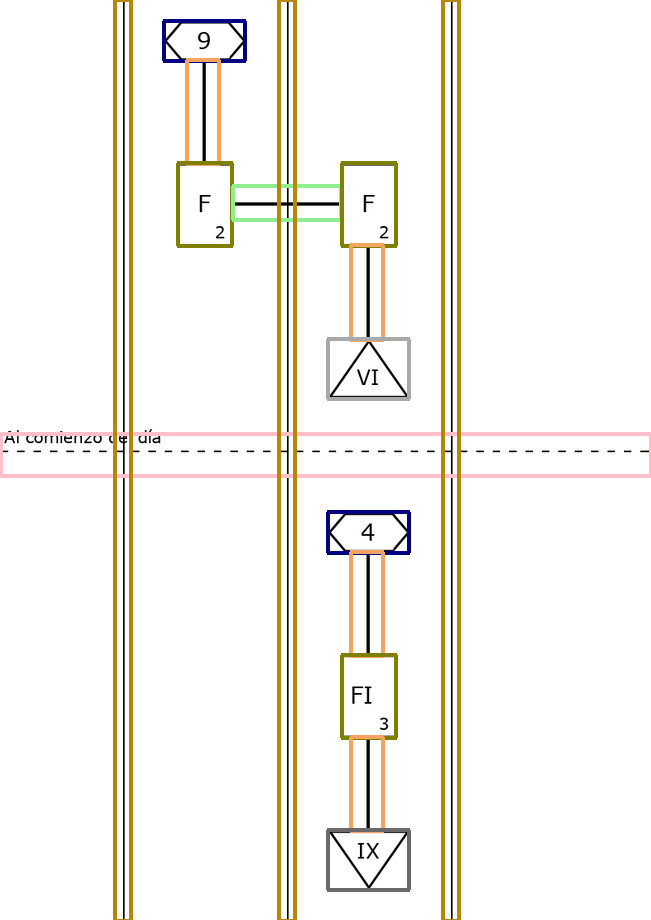



 14 >  da_curso_SARV_000223-z87.xml




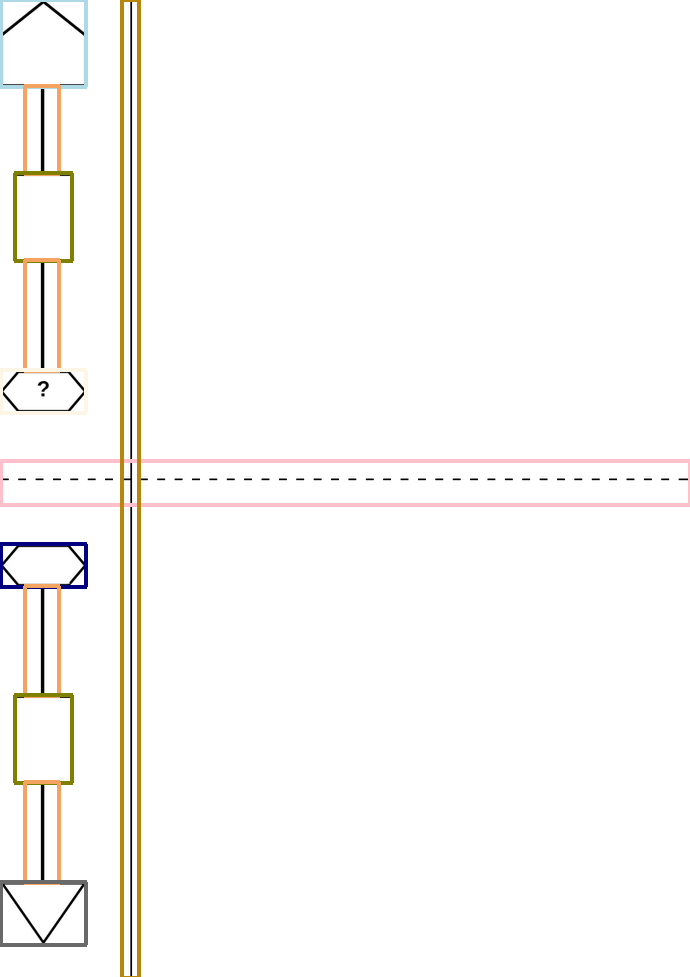



 15 >  da_curso_SARA_000221-z44.xml




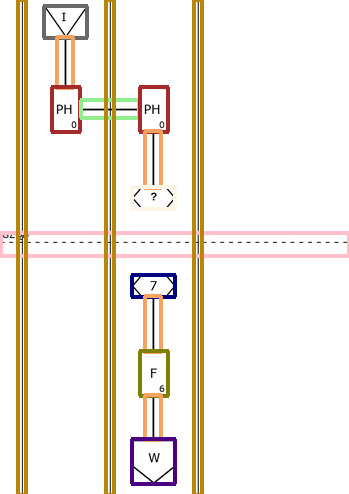



 16 >  da_curso_SFRA_000241-z50.xml




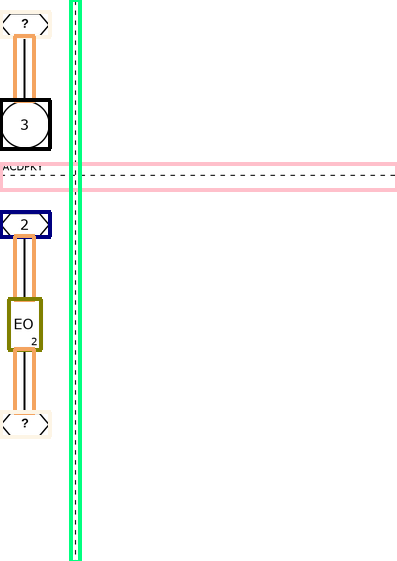



 17 >  da_curso_SARS_000032-z40.xml




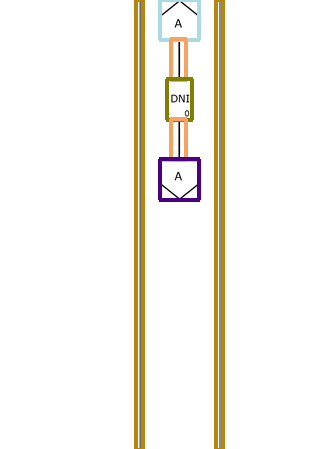



 18 >  da_curso_SFRS_000128-z71.xml




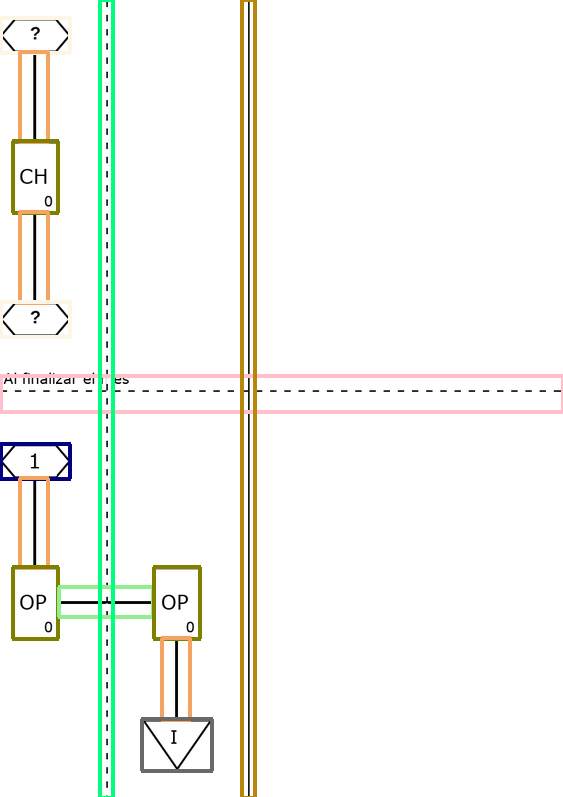



 19 >  da_curso_SFRA_000007-z49.xml




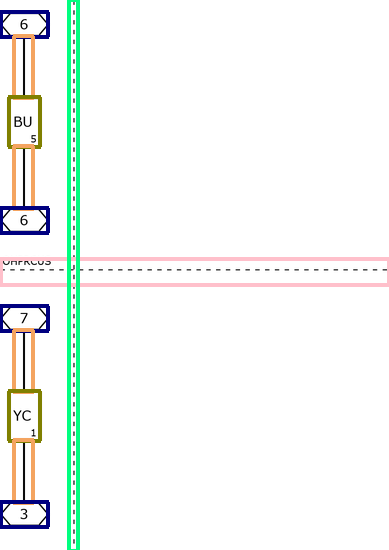



 20 >  da_curso_SFRS_000208-z60.xml




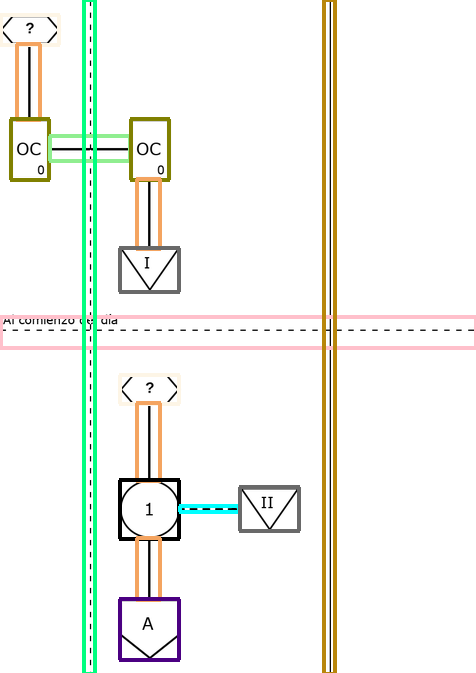



 21 >  da_curso_SPRS_000156-z68.xml




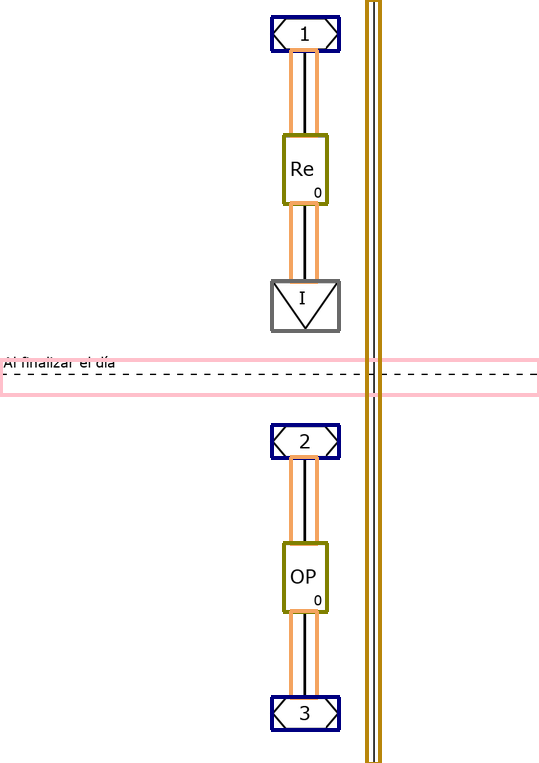



 22 >  da_curso_SFRS_000168-z28.xml




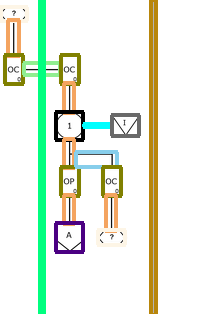



 23 >  da_curso_SFRS_000189-z78.xml




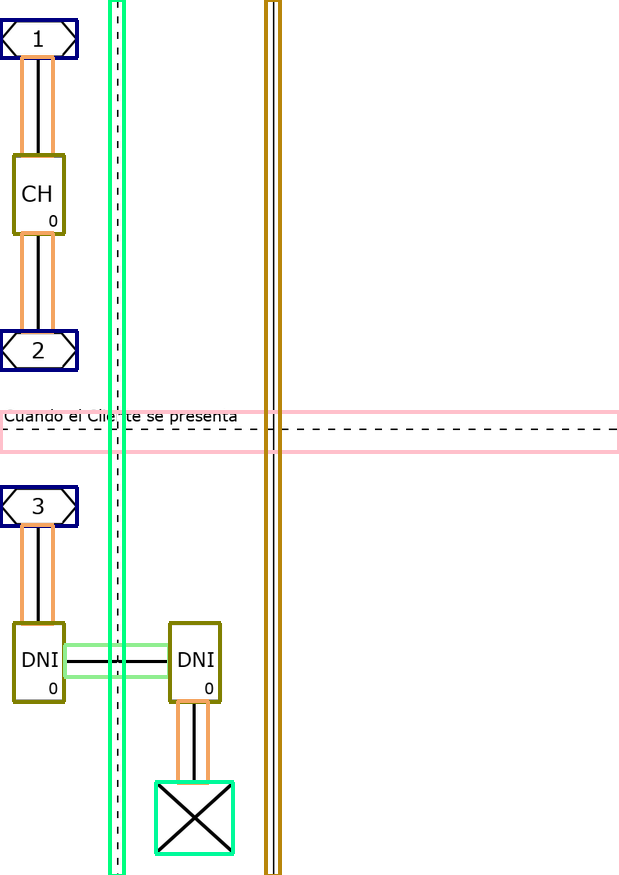



 24 >  da_curso_SARV_000075-z38.xml




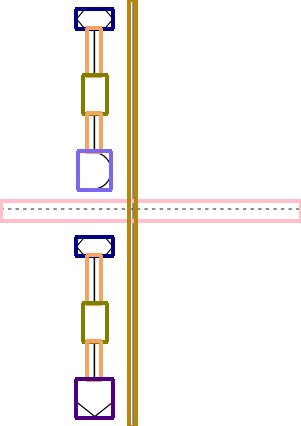



 25 >  da_curso_SARC_000086-z80.xml




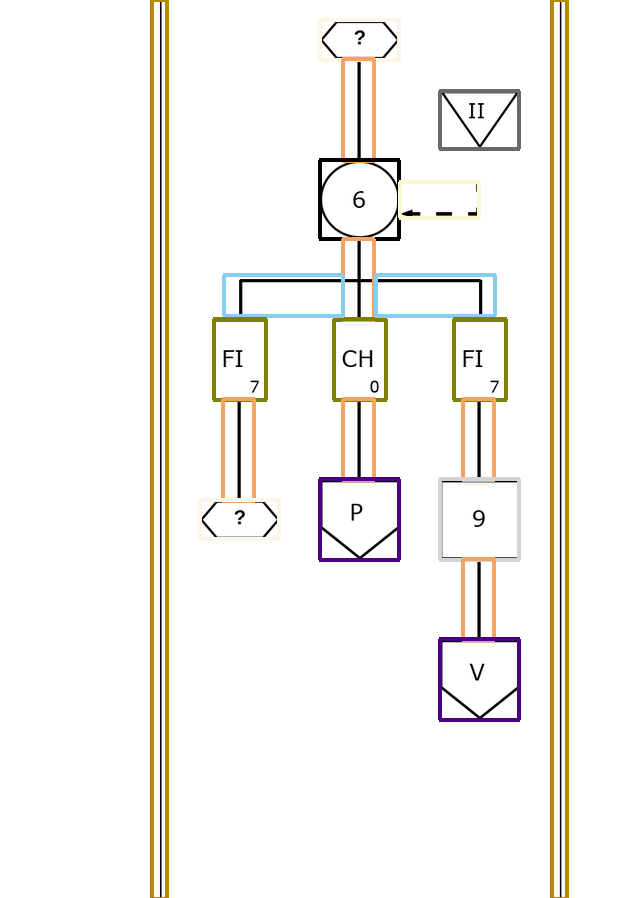



 26 >  da_curso_SFRA_000013-z87.xml




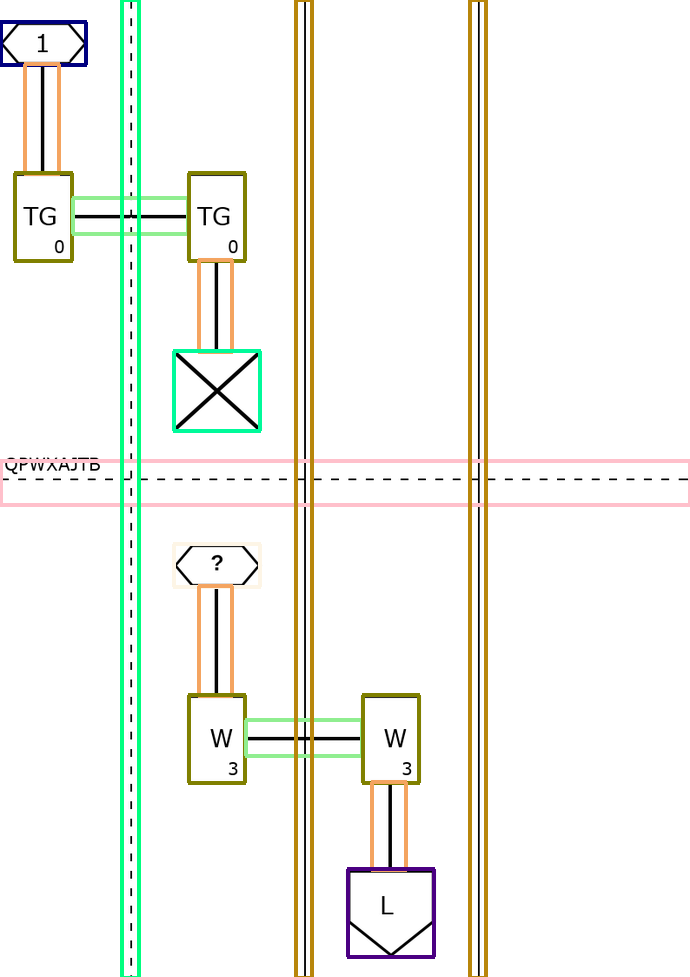



 27 >  da_curso_SFRS_000197-z33.xml




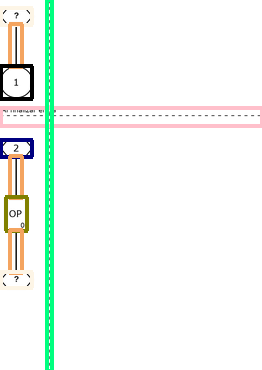



 28 >  da_curso_SPRV_000041-z64.xml




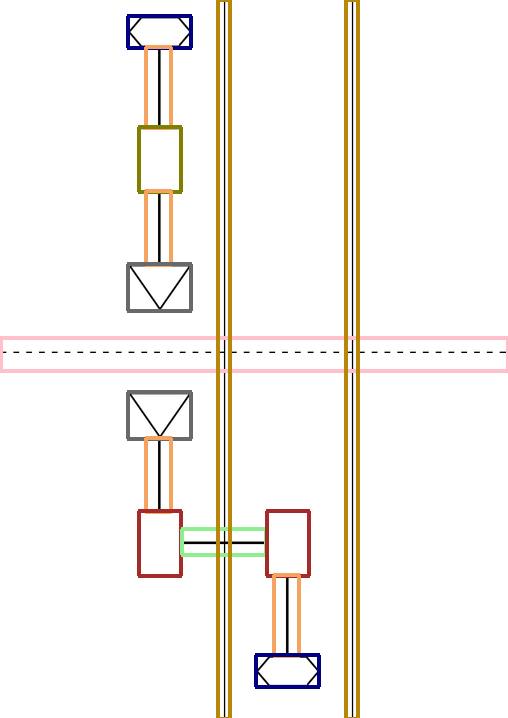



 29 >  da_curso_SFRS_000156-z83.xml




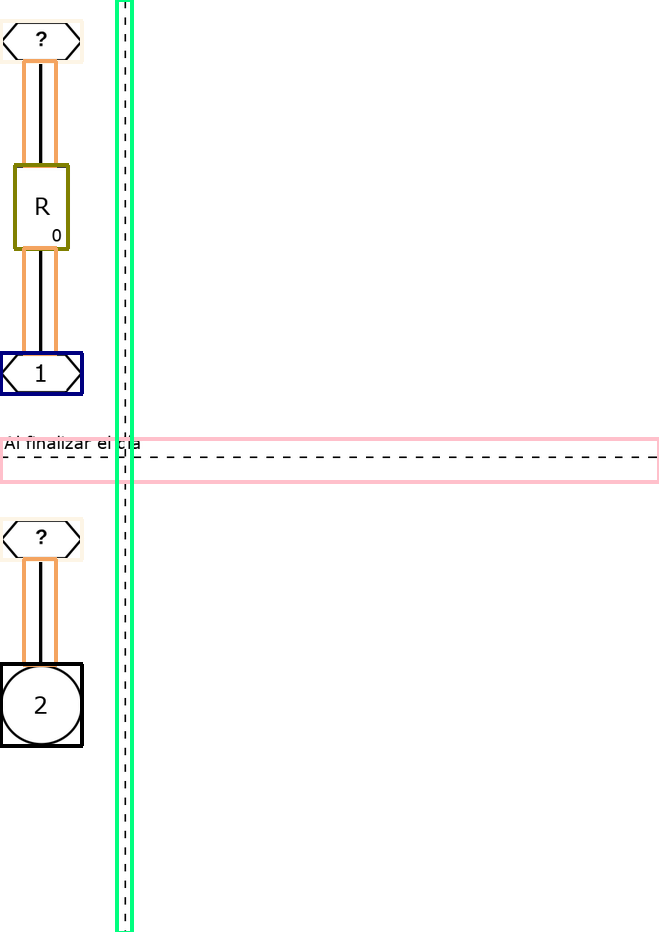



 30 >  da_curso_SFRS_000216-z31.xml




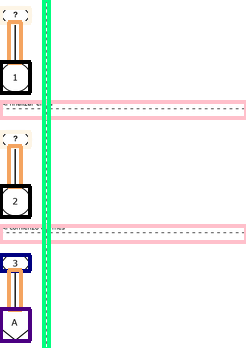



 31 >  da_curso_SARA_000078-z24.xml




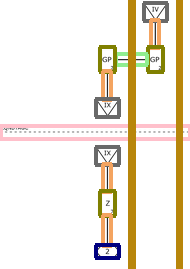



 32 >  da_curso_SPRA_000264-z69.xml




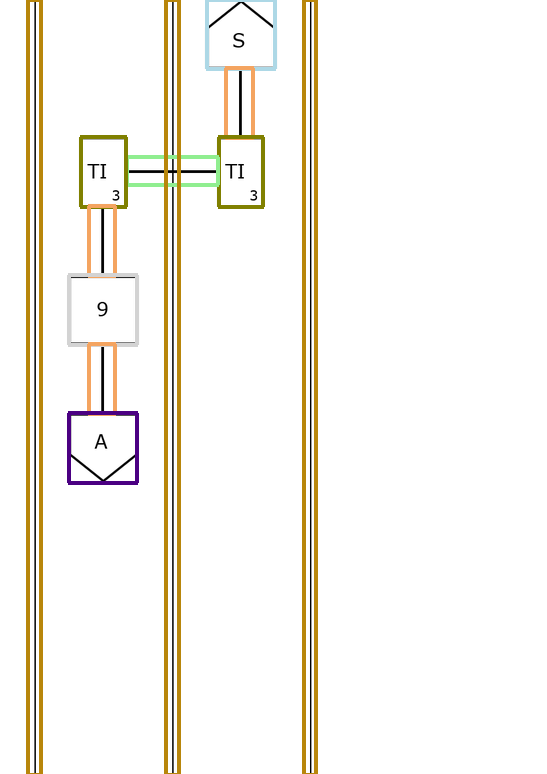



 33 >  da_curso_SFRA_000025-z34.xml




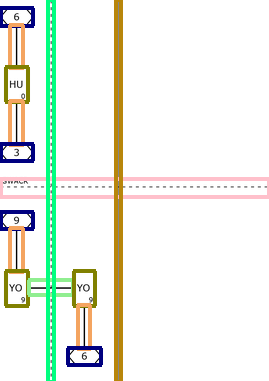



 34 >  da_curso_SARV_000195-z50.xml




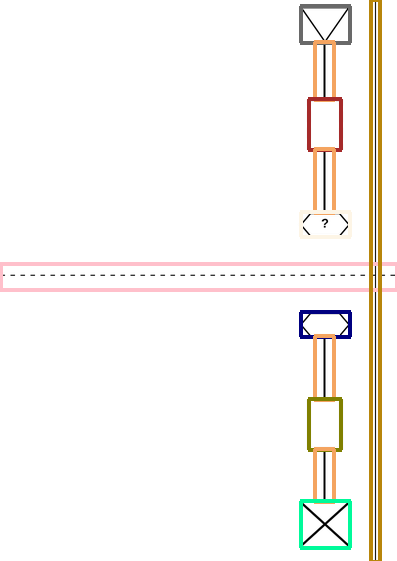



 35 >  da_curso_SARV_000233-z61.xml




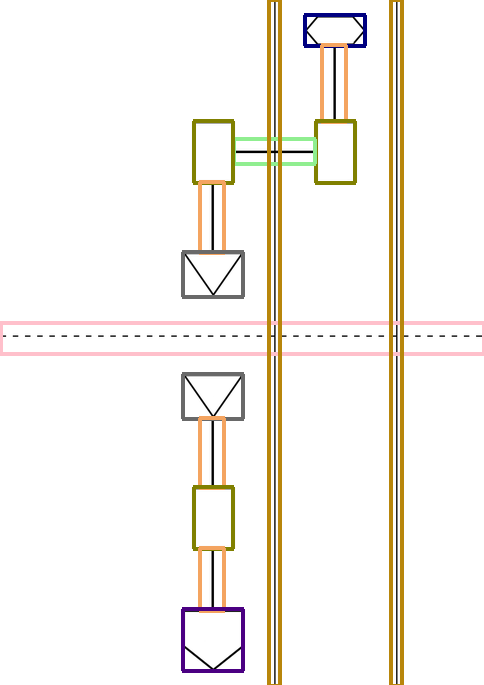



 36 >  da_curso_SFRS_000190-z60.xml




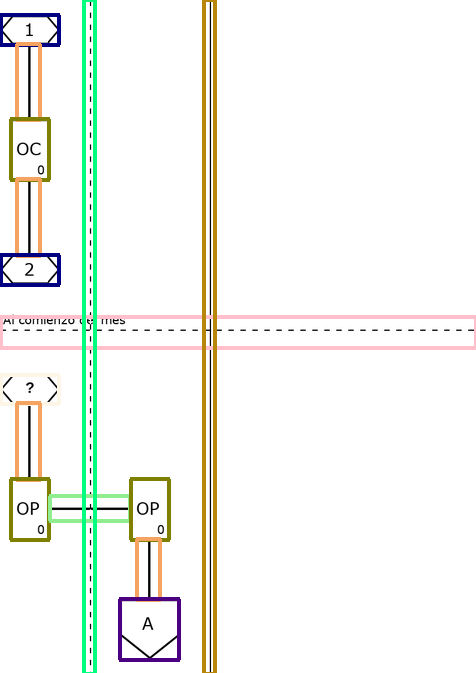



 37 >  da_curso_SFRA_000196-z77.xml




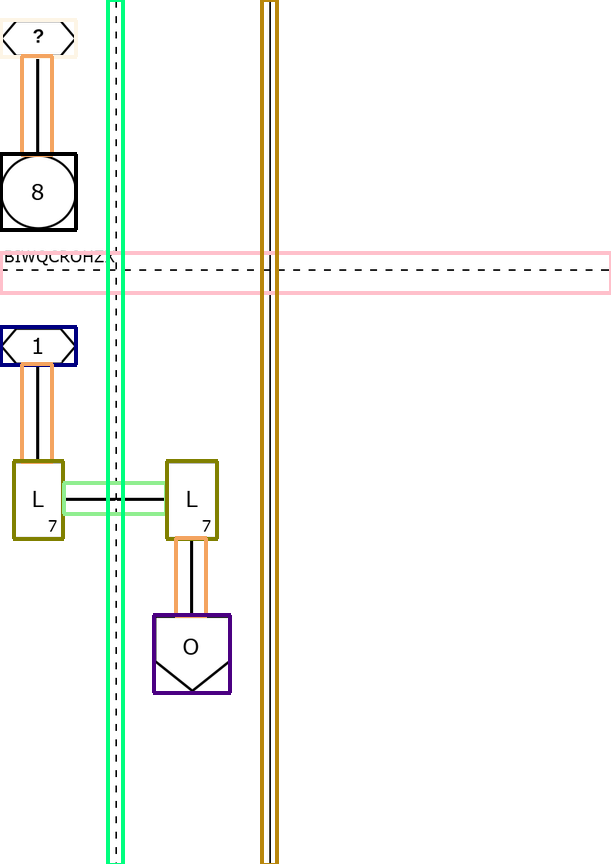



 38 >  da_curso_SFRA_000043-z53.xml




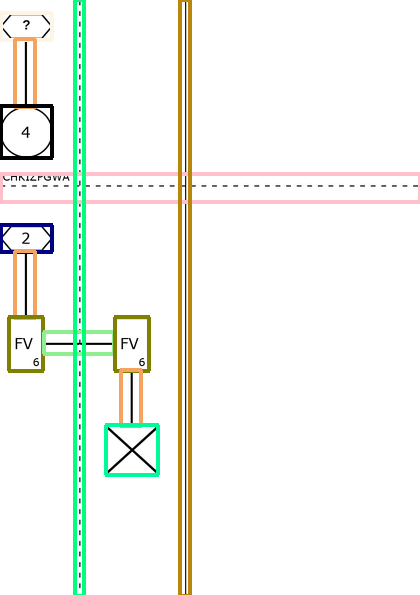



 39 >  da_curso_SARS_000131-z32.xml




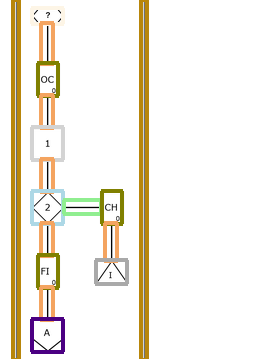



 40 >  da_curso_SARV_000052-z71.xml




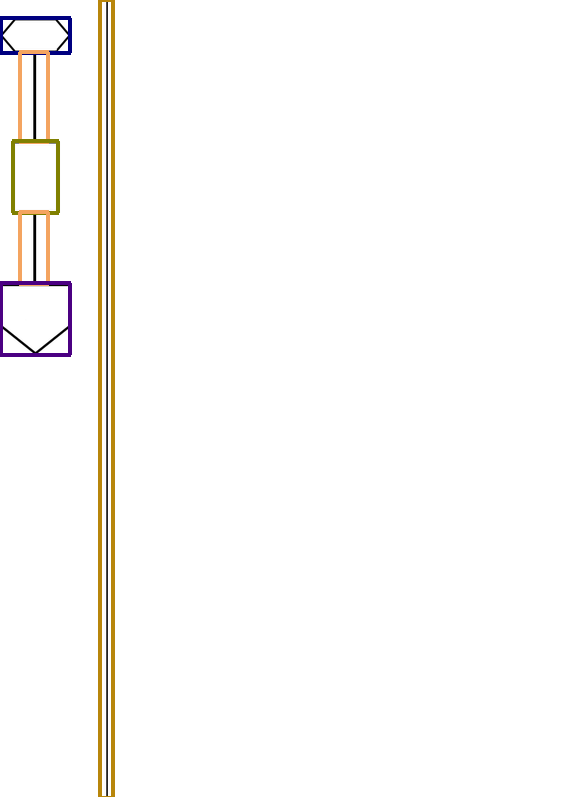



 41 >  da_curso_SARS_000090-z76.xml




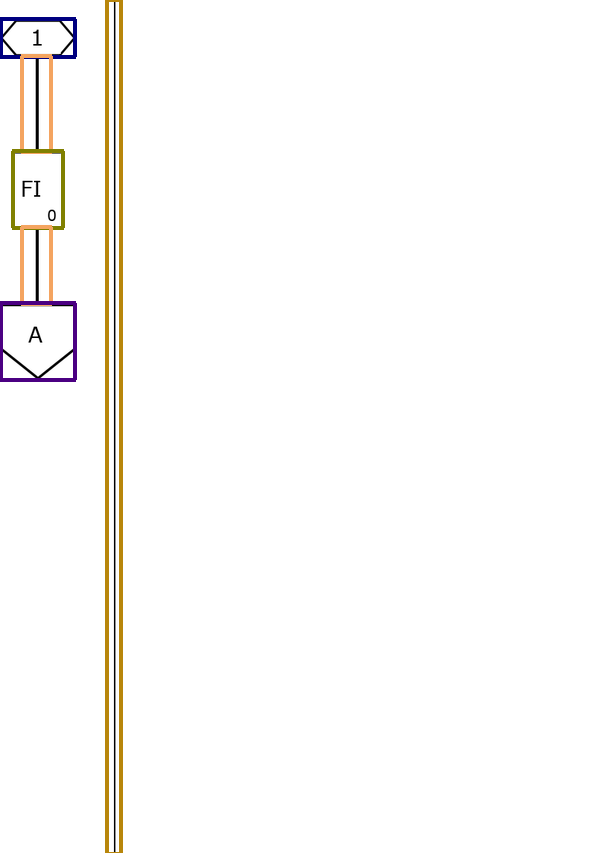



 42 >  da_curso_SARV_000173-z31.xml




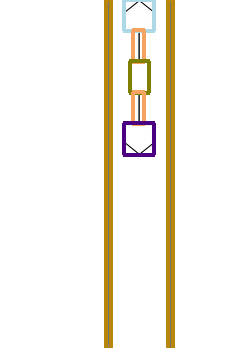



 43 >  da_curso_SFRS_000255-z79.xml




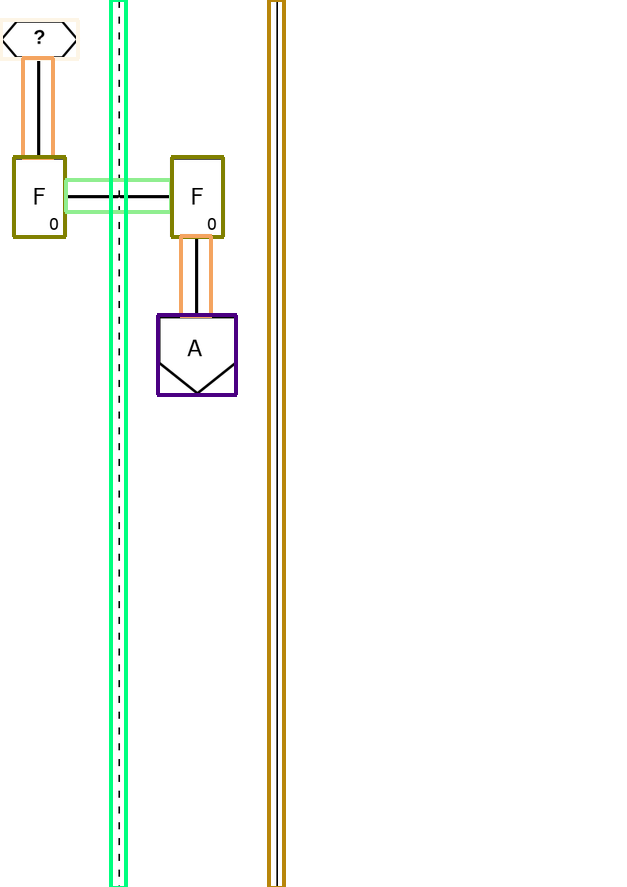



 44 >  da_curso_SFRS_000206-z56.xml




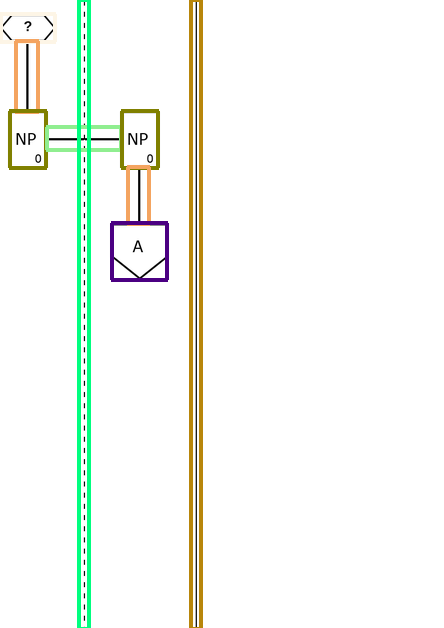



 45 >  da_curso_SFRS_000151-z42.xml




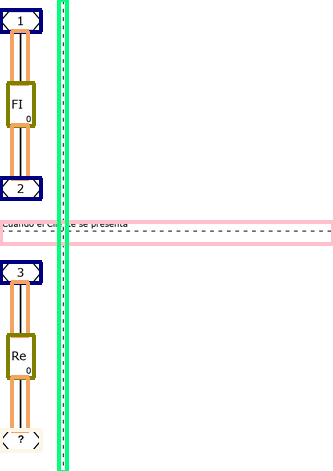



 46 >  da_curso_SFRS_000107-z71.xml




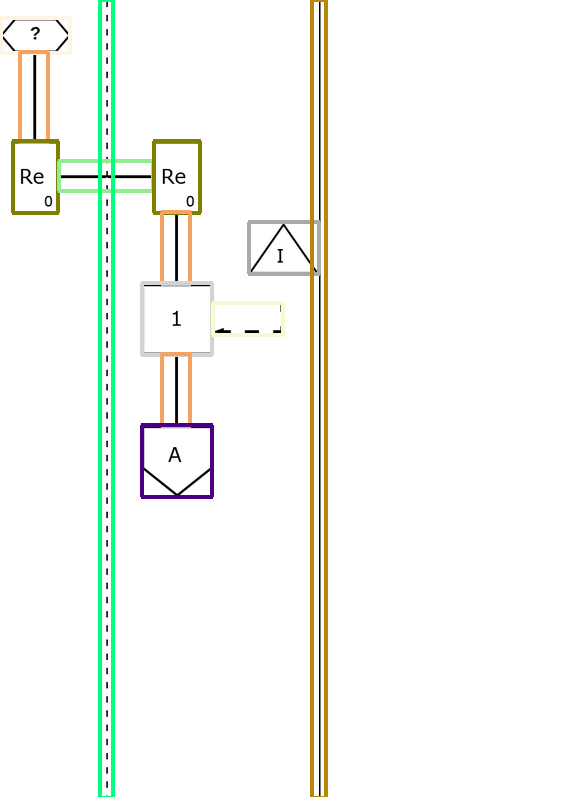



 47 >  da_curso_SARA_000078-z21.xml




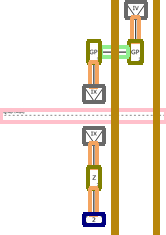



 48 >  da_curso_SARA_000033-z62.xml




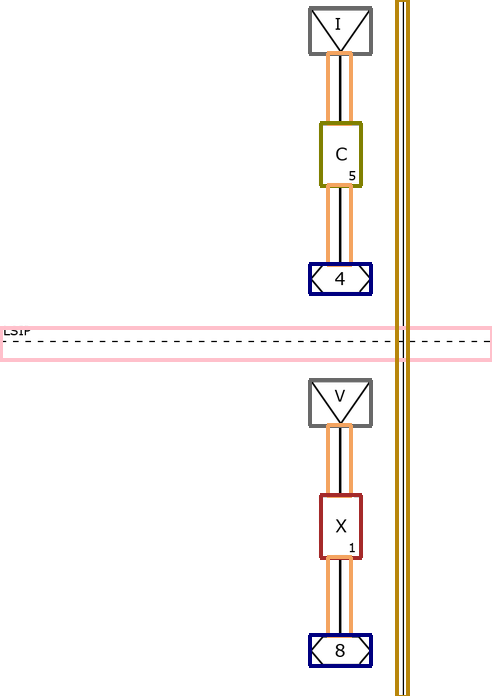



 49 >  da_curso_SARC_000159-z52.xml




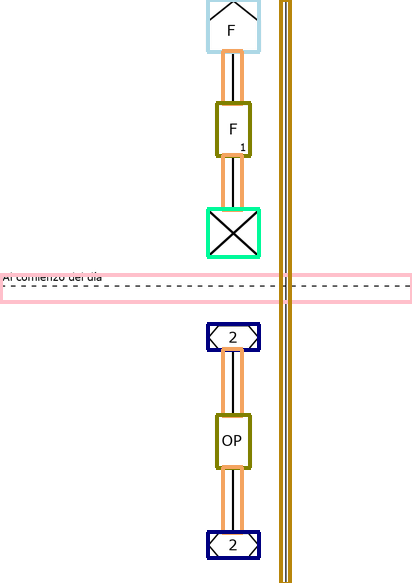



 50 >  da_curso_SPRS_000082-z56.xml




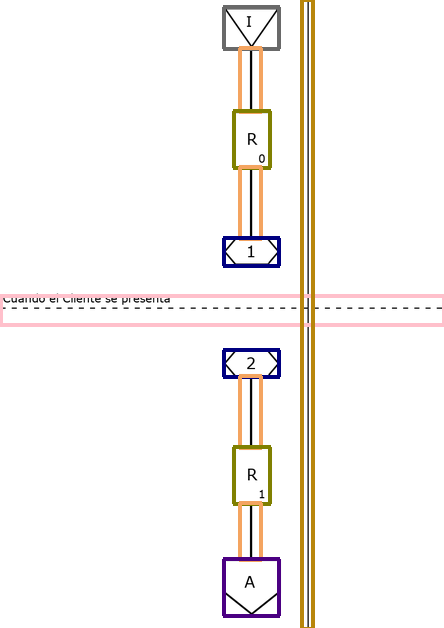



 51 >  da_curso_SPRA_000054-z68.xml


 52 >  da_curso_SARV_000088-z46.xml


 53 >  da_curso_SPRV_000070-z45.xml


 54 >  da_curso_SARV_000092-z29.xml


 55 >  da_curso_SARA_000162-z30.xml


 56 >  da_curso_SFRS_000196-z38.xml


 57 >  da_curso_SFRS_000142-z69.xml


 58 >  da_curso_SPRA_000032-z43.xml


 59 >  da_curso_SFRA_000028-z27.xml


 60 >  da_curso_SARS_000038-z40.xml


 61 >  da_curso_SFRS_000168-z48.xml


 62 >  da_curso_SPRS_000124-z45.xml


 63 >  da_curso_SPRA_000054-z32.xml


 64 >  da_curso_SARC_000129-z34.xml


 65 >  da_curso_SPRS_000090-z72.xml


 66 >  da_curso_SPRC_000007-z64.xml


 67 >  da_curso_SPRV_000262-z82.xml


 68 >  da_curso_SFRS_000233-z47.xml


 69 >  da_curso_SARC_000269-z80.xml


 70 >  da_curso_SARC_000095-z81.xml


 71 >  da_curso_SARS_000154-z61.xml


 72 >  da_curso_SFRS_000228-z74.xml


 73 >  da_curso_SFRS_000270-z77.xml


 74 >  da_curso_SFRS_000175-z54.xml


 75 >  da_curso_SARS_000232-z87.xml


 76 >  da_curso_SPRV_000018-z37.xml


 77 >  da_

KeyboardInterrupt: ignored

In [18]:
#@title Muestra imágenes con XML

# arma lista de colores para los recuados
colors = list(ImageColor.colormap.values())
colors = sorted(colors, key=lambda _: _[1])


# función auxiliar para hacer el chequeo
def checkValoresXML(valMin, valMax, limiteMax, descVal, xml_file, class_name):
  res = 0
  
  if valMin < 0:
    print("**", xml_file, '-', class_name, 'error: ', descVal, 'min [', valMin, '] < 0')
    res = res + 1
  
  if valMax < 0:
    print("**", xml_file, '-', class_name, 'error: ', descVal, 'max [', valMax, '] < 0')
    res = res + 1

  if valMin > limiteMax:
    print("**", xml_file, '-', class_name, 'error: ', descVal, 'min [', valMin, '] > límiteMáximo [', limiteMax, '].')
    res = res + 1
  
  if valMax > limiteMax:
    print("**", xml_file, '-', class_name, 'error: ', descVal, 'max [', valMax, ']  > límiteMáximo [', limiteMax, '].')
    res = res + 1

  if valMin < 0:
    print("**", xml_file, '-', class_name, 'error: ', descVal, 'min [', valMin, '] < 0.')
    res = res + 1
  
  if valMax < 0:
    print("**", xml_file, '-', class_name, 'error: ', descVal, 'max [', valMax, '] < 0.')
    res = res + 1

  if valMin >= valMax:
      if valMin > valMax:
          print("**", xml_file, '-', class_name, 'error: ', descVal, 'min [', valMin, '] > ', descVal, 'max [', valMax, '].')
          res = res + 1
      else:
          print("**", xml_file, '-', class_name, 'error: ', descVal, 'min [', valMin, '] = ', descVal, 'max[', valMax, '].')
          res = res + 1
  
  return res

# variable auxiliar
cantErroresTotales = 0
cantProcesados = 0 
# procesa los XMLs
for xml_file in all_xml_array:
    cantProcesados = cantProcesados + 1
    print("\n\n", cantProcesados,"> ", xml_file)
    
    # decide si muestra la imagen asociada a este XML
    muestraImagen = ((xml_file in mostrar_xml_array) and mostrarObjetosEnImagen)

    # carga la info del XML original
    et = ET.parse(data_dir_path + '/' + xml_file)
    element = et.getroot()
    element_objs = element.findall('object') 
    element_filename = element.find('filename').text
    ##if not('.png' in element_filename):
    ##    element_filename  = element_filename + '.png'
    img_filename = os.path.join(image_dir_path, element_filename)
    
    # carga la imagen
    imageCargada = ImPIL.open(img_filename)
    if mostrarImagenOriginal: 
        display( imageCargada )

    # imagen auxiliar para mostrar recuadros
    img = tf.io.read_file(img_filename)
    img = tf.image.decode_jpeg(img, channels=3)
    img = img.numpy()
    image_pil = Image.fromarray(np.uint8(img)).convert("RGB")
    draw = ImageDraw.Draw(image_pil)
    im_width, im_height = image_pil.size

    # variables auxiliares para chequear duplicados
    auxListCheckDupPos = []
    auxListCheckDupClass = []
    cantErrores = 0

    # procesa los elementos en el archivo XML original para generar el nuevo
    for element_obj in element_objs:

        # obtiene la información actual de la imagen
        class_name = element_obj.find('name').text 

        # obtiene info del box actual
        obj_bbox = element_obj.find('bndbox')
        x1 = int(round(float(obj_bbox.find('xmin').text)))
        y1 = int(round(float(obj_bbox.find('ymin').text)))
        x2 = int(round(float(obj_bbox.find('xmax').text)))
        y2 = int(round(float(obj_bbox.find('ymax').text)))

        # realiza el chequeo del XML
        cantErrores = checkValoresXML(x1, x2, im_width, 'X', xml_file, class_name) + cantErrores
        cantErrores = checkValoresXML(y1, y2, im_height, 'Y', xml_file, class_name) + cantErrores
        
        auxVec = (x1, y1, x2, y2)        
        if auxVec in auxListCheckDupPos:
            i = auxListCheckDupPos.index( auxVec )
            print("**", xml_file, '- [', class_name, ',', auxVec, '] error registro duplicado con [', auxListCheckDupClass[i], ',', auxListCheckDupPos[i], '].')
            cantErrores = cantErrores + 1
        else:
            auxListCheckDupPos.append( auxVec )
            auxListCheckDupClass.append( class_name )

        if extraerObjetos:
            # extrae los objetos de la imagen
            print("  --- ", class_name)  
            imBox = imageCargada.crop((x1,y1,x2,y2))
            display( imBox )

        if muestraImagen:
            # genera los recuadros correspondientes
            color = colors[(hash(class_name)) % len(colors)]
            if color == "#ffffff":
              color = "#000000"
            draw.line([(x1, y1), (x1, y2), (x2, y2), (x2, y1), (x1, y1)], width=4, fill=color)
             
    ##print("\n== Cantidad de Errores encontrados: ", cantErrores)
    cantErroresTotales = cantErroresTotales + cantErrores 
    
    if muestraImagen:
       # muestra la imagen con los recuadros correspondientes
       ##np.copyto(img, np.array(image_pil))
       print("\n")
       imMostrar = Image.fromarray(np.array(image_pil), 'RGB')
       display( imMostrar )

print("\n\n== Cantidad de XMLs chequeados: ", cantProcesados)
print("\n== Cantidad de Errores Totales encontrados: ", cantErroresTotales)